In [ ]:
#NO1

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Employee Data Example") \
    .getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

df = spark.createDataFrame(data, schema=columns)

df.createOrReplaceTempView('employees')

spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) AS avg_salary FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|        avg_salary|
+------------------+
|3266.6666666666665|
+------------------+



In [ ]:
#NO2

In [3]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [ ]:
#TUGAS1-3

In [4]:
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
''').show()


+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [5]:
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
) g ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
''').show()


+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [6]:
spark.sql('''
SELECT 
    Name, DeptId, Salary,
    RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
FROM employees
''').show()

+-----+------+------+----------+
| Name|DeptId|Salary|RankInDept|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [ ]:
#NO3

In [7]:
spark.sql('''
SELECT Name, Age, Salary, 
       ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) AS rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [ ]:
#NO4

In [19]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])

employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

result = spark.sql('''
SELECT 
    e.Name, 
    e.Age, 
    e.Gender,
    e.Salary, 
    d.DeptName, 
    p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
ORDER BY e.DeptId, e.Salary DESC
''')
result.show()

+-----+---+------+------+---------+-----------+
| Name|Age|Gender|Salary| DeptName|ProjectName|
+-----+---+------+------+---------+-----------+
|James| 34|     M|  3000|       HR|  Project A|
|  Lee| 23|     M|  2700|       HR|  Project A|
| Anna| 28|     F|  4100|Marketing|  Project B|
+-----+---+------+------+---------+-----------+



In [ ]:
#TUGAS5&6

In [9]:
spark.sql('''
SELECT 
    e.Name,
    e.DeptId,
    d.DeptName,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY e.DeptId) AS AvgSalaryDept,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS RankInDept
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, RankInDept
''').show()

+-----+------+---------+------+-------------+----------+
| Name|DeptId| DeptName|Salary|AvgSalaryDept|RankInDept|
+-----+------+---------+------+-------------+----------+
|James|     1|       HR|  3000|       2850.0|         1|
|  Lee|     1|       HR|  2700|       2850.0|         2|
| Anna|     2|Marketing|  4100|       4100.0|         1|
+-----+------+---------+------+-------------+----------+



In [10]:
spark.sql('''
SELECT 
    e.Name,
    e.DeptId,
    d.DeptName,
    e.Age,
    e.Salary,
    LAG(e.Salary, 1) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS PrevSalary,
    Salary - LAG(e.Salary, 1) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS SalaryTrend
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, e.Age
''').show()


+-----+------+---------+---+------+----------+-----------+
| Name|DeptId| DeptName|Age|Salary|PrevSalary|SalaryTrend|
+-----+------+---------+---+------+----------+-----------+
|  Lee|     1|       HR| 23|  2700|      NULL|       NULL|
|James|     1|       HR| 34|  3000|      2700|        300|
| Anna|     2|Marketing| 28|  4100|      NULL|       NULL|
+-----+------+---------+---+------+----------+-----------+



In [ ]:
#NO5

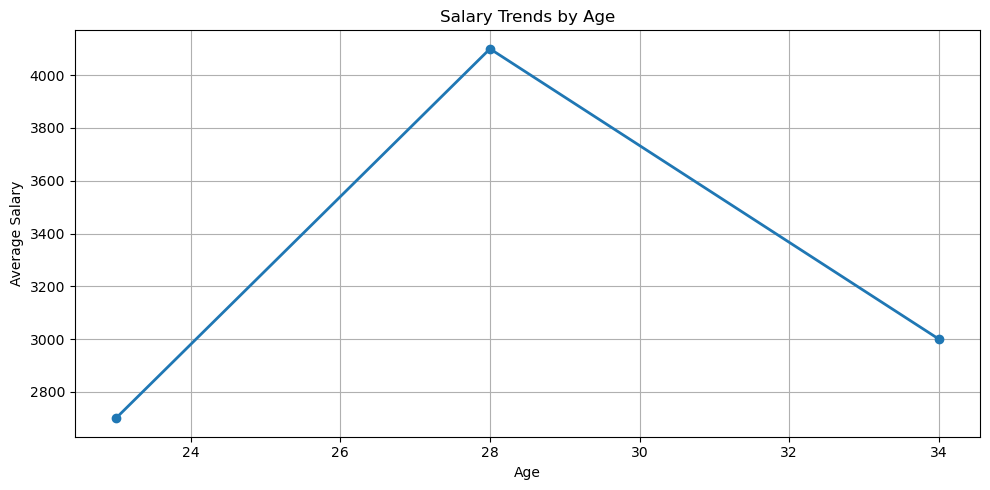

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

salary_trends = spark.sql('''
SELECT 
    Age, 
    AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas() 

plt.figure(figsize=(10, 5))
plt.plot(
    salary_trends['Age'], 
    salary_trends['AverageSalary'], 
    marker='o', 
    linestyle='-', 
    linewidth=2
)
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#HOMEWORKKKKKKKK

In [ ]:
#NO.1HOMEWORK

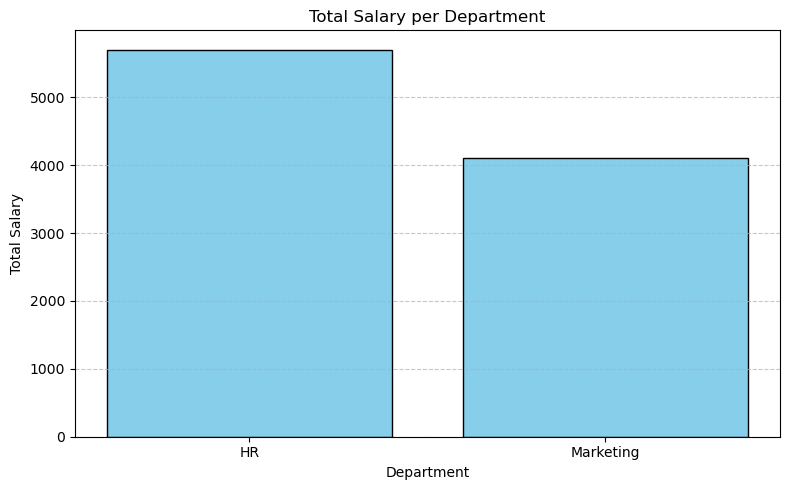

    DeptName  TotalSalary  EmployeeCount
0         HR         5700              2
1  Marketing         4100              1


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

dept_summary = spark.sql('''
SELECT 
    d.DeptName,
    SUM(e.Salary) AS TotalSalary,
    COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''').toPandas()

plt.figure(figsize=(8, 5))
plt.bar(dept_summary['DeptName'], dept_summary['TotalSalary'], color='skyblue', edgecolor='black')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(dept_summary)

In [ ]:
#NO.2HOMEWORK

+----+---+------+------------------+
|Name|Age|Salary|          AvgByAge|
+----+---+------+------------------+
| Ben| 23|  3100|            2900.0|
|Anna| 28|  4100|4066.6666666666665|
|Ella| 28|  4200|4066.6666666666665|
|John| 34|  4500|3566.6666666666665|
+----+---+------+------------------+



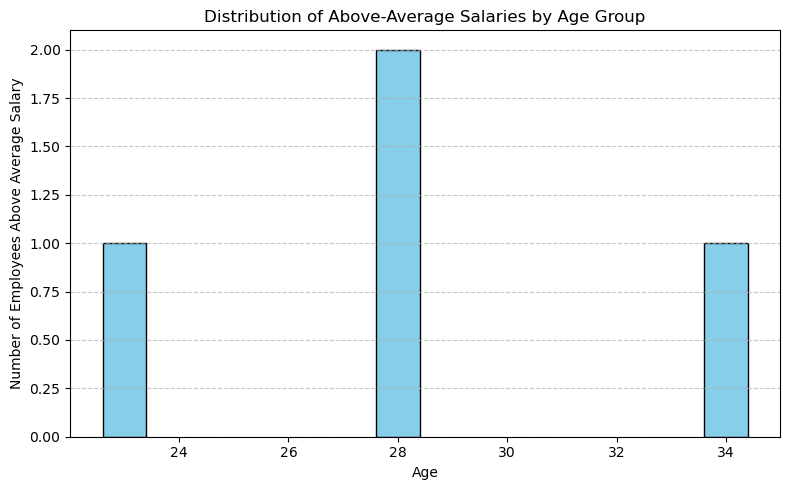

In [22]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("Pertemuan9").getOrCreate()

employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('John', 34, 'M', 4500, 1),
    ('Maria', 28, 'F', 3900, 2),
    ('Ben', 23, 'M', 3100, 1),
    ('Ella', 28, 'F', 4200, 2),
    ('Tom', 34, 'M', 3200, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

employees.createOrReplaceTempView("employees")

avg_salary = spark.sql('''
SELECT 
    Name,
    Age,
    Salary,
    AVG(Salary) OVER (PARTITION BY Age) AS AvgByAge
FROM employees
''')

above_avg = avg_salary.filter('Salary > AvgByAge')
above_avg.show()

df_above = above_avg.groupBy('Age').count().toPandas()

plt.figure(figsize=(8,5))
plt.bar(df_above['Age'], df_above['count'], color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Employees Above Average Salary')
plt.title('Distribution of Above-Average Salaries by Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#NO.3HOMEWORKKKK

A. Department Aggregation
+------+-----------+-------------+-----------+-----------------+
|DeptId|DeptName   |EmployeeCount|TotalSalary|AvgSalary        |
+------+-----------+-------------+-----------+-----------------+
|4     |Sales      |36           |248099     |6891.638888888889|
|3     |Engineering|24           |194939     |8122.458333333333|
|2     |Marketing  |32           |190679     |5958.71875       |
|5     |Finance    |28           |181081     |6467.178571428572|
|1     |HR         |30           |139799     |4659.966666666666|
+------+-----------+-------------+-----------+-----------------+

B. Top 5 Earners per Department
+--------------+------+------+
|Name          |DeptId|Salary|
+--------------+------+------+
|Rika Budi     |1     |6239  |
|Brian Budi    |1     |6216  |
|Diana Haris   |1     |6209  |
|Joko Haris    |1     |5850  |
|Maya Indah    |1     |5848  |
|Nico Jaya     |2     |8706  |
|George Gunawan|2     |8355  |
|Kiki Dewi     |2     |8211  |
|Qori Jaya     

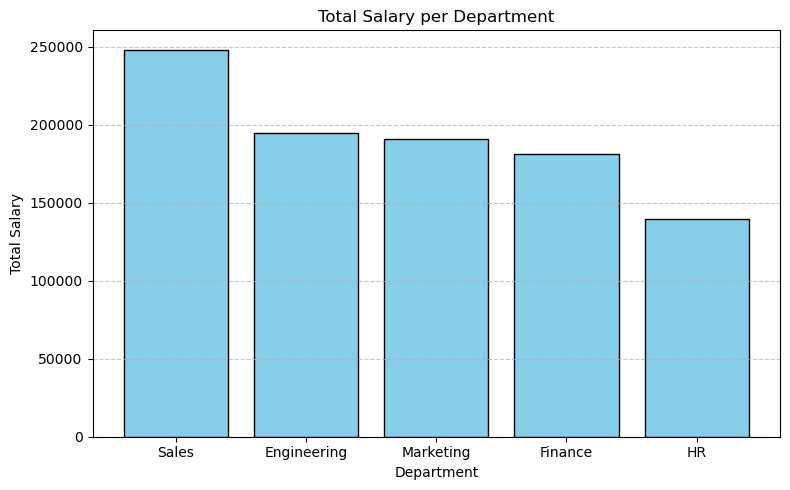

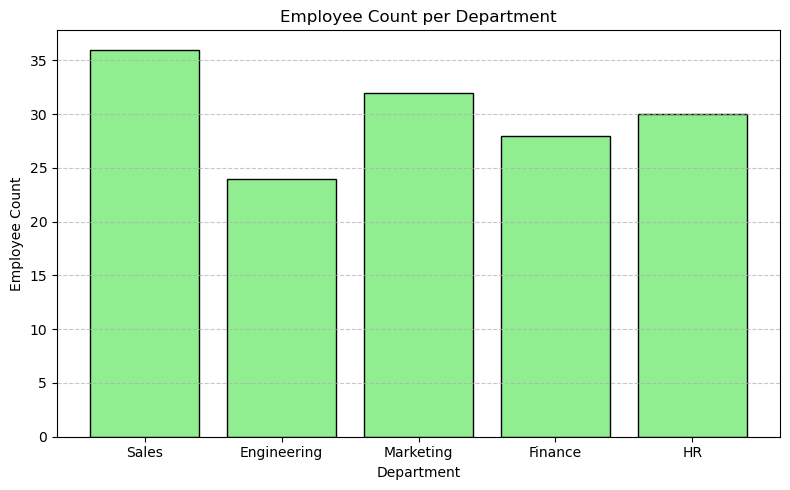

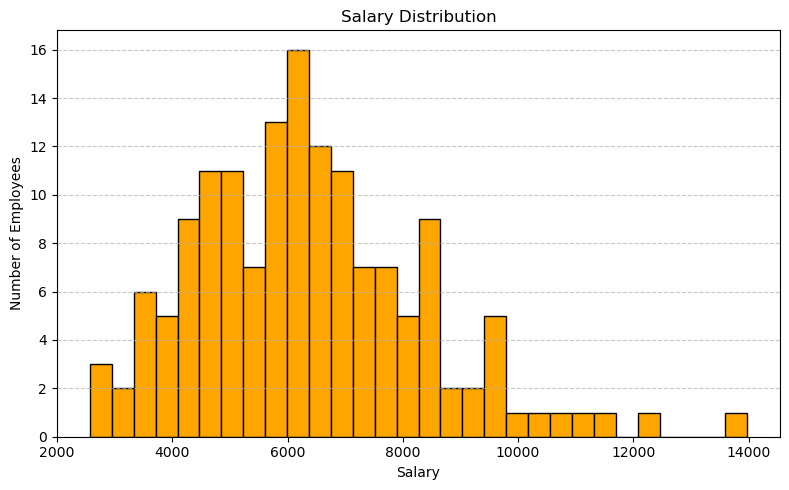

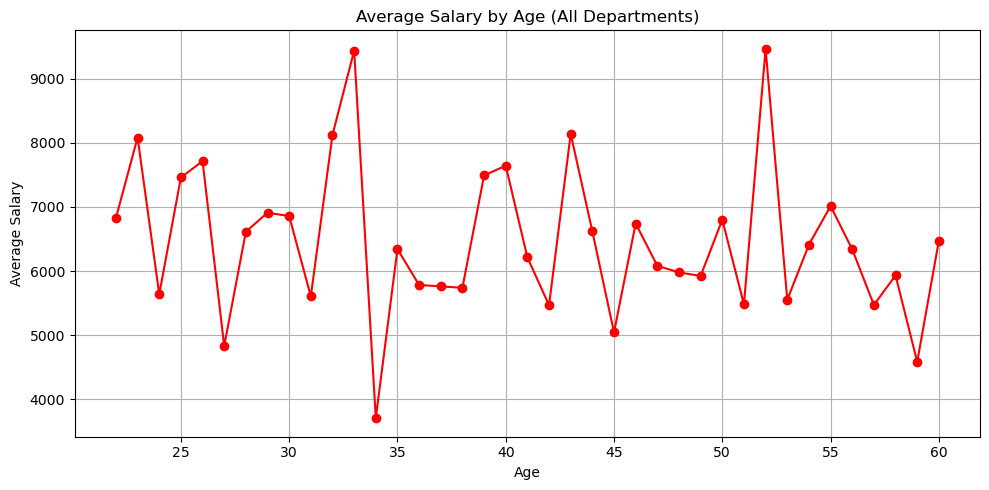

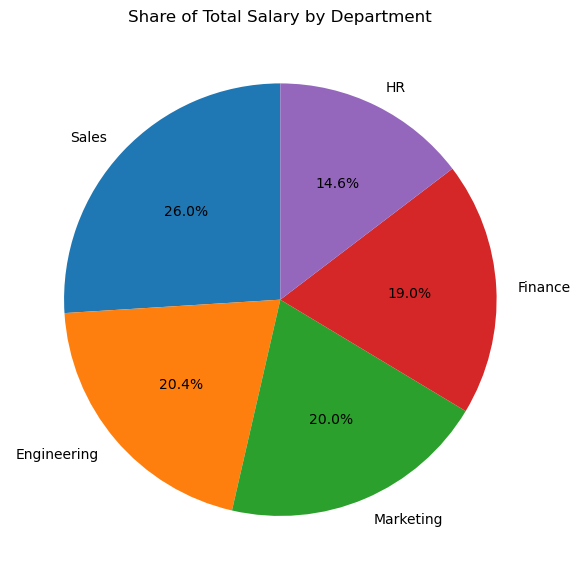

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import random
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("DeepSparkSQL_150").getOrCreate()
random.seed(42)

dept_list = [
    (1, "HR"),
    (2, "Marketing"),
    (3, "Engineering"),
    (4, "Sales"),
    (5, "Finance"),
]
projects_list = [
    (1, "HR Onboarding"),
    (2, "Digital Campaign"),
    (3, "Platform Rework"),
    (4, "Enterprise Sales"),
    (5, "Budget Forecast")
]

first_names = ['Alex','Brian','Cathy','Diana','Evan','Fiona','George','Hana','Irfan','Joko',
               'Kiki','Lina','Maya','Nico','Omar','Putu','Qori','Rika','Sari','Tono']
last_names = ['Adi','Budi','Citra','Dewi','Eka','Farah','Gunawan','Haris','Indah','Jaya']

employees_data = []
num_employees = 150

for i in range(num_employees):
    name = f"{random.choice(first_names)} {random.choice(last_names)}"
    age = random.randint(22, 60)
    gender = random.choice(['M', 'F'])
    dept = random.choice([d[0] for d in dept_list])
    
    # Salary by dept (different average levels)
    if dept == 3:  # Engineering
        salary = int(random.gauss(9000, 2000))
    elif dept == 4:  # Sales
        salary = int(random.gauss(7000, 2500))
    elif dept == 2:  # Marketing
        salary = int(random.gauss(6000, 1500))
    elif dept == 5:  # Finance
        salary = int(random.gauss(6500, 1200))
    else:  # HR
        salary = int(random.gauss(4500, 1000))
    salary = max(2000, salary)  
    
    hire_year = random.randint(2010, 2024)
    perf = round(random.uniform(2.5, 5.0), 2)
    employees_data.append((name, age, gender, salary, dept, hire_year, perf))

employees = spark.createDataFrame(employees_data,
                                  ['Name', 'Age', 'Gender', 'Salary', 'DeptId', 'HireYear', 'PerfScore'])

departments = spark.createDataFrame(dept_list, ['DeptId', 'DeptName'])
projects = spark.createDataFrame(projects_list, ['DeptId', 'ProjectName'])

employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# A. Total salary and employee count per department
dept_agg = spark.sql('''
SELECT d.DeptId, d.DeptName,
       COUNT(e.Name) AS EmployeeCount,
       SUM(e.Salary) AS TotalSalary,
       AVG(e.Salary) AS AvgSalary
FROM departments d
LEFT JOIN employees e ON d.DeptId = e.DeptId
GROUP BY d.DeptId, d.DeptName
ORDER BY TotalSalary DESC
''')
print("A. Department Aggregation")
dept_agg.show(truncate=False)

# B. Top 5 earners per department
top_earners = spark.sql('''
SELECT Name, DeptId, Salary
FROM (
  SELECT Name, DeptId, Salary,
         RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS rk
  FROM employees
) t
WHERE rk <= 5
ORDER BY DeptId, rk
''')
print("B. Top 5 Earners per Department")
top_earners.show(20, truncate=False)

# C. Employees above department average salary
above_dept_avg = spark.sql('''
SELECT e.Name, e.DeptId, d.DeptName, e.Salary, dept_avg.AvgSalary
FROM employees e
JOIN (
    SELECT DeptId, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY DeptId
) dept_avg ON e.DeptId = dept_avg.DeptId
JOIN departments d ON e.DeptId = d.DeptId
WHERE e.Salary > dept_avg.AvgSalary
ORDER BY e.DeptId, e.Salary DESC
''')
print("C. Employees Above Dept Avg")
above_dept_avg.show(20, truncate=False)

# D. Salary trend by age using LAG()
salary_trend = spark.sql('''
SELECT Name, DeptId, Age, Salary,
       LAG(Salary,1) OVER (PARTITION BY DeptId ORDER BY Age) AS PrevSalary,
       Salary - LAG(Salary,1) OVER (PARTITION BY DeptId ORDER BY Age) AS DeltaFromPrev
FROM employees
ORDER BY DeptId, Age
''')
print("D. Salary Trend by Age per Dept (sample)")
salary_trend.show(10, truncate=False)


dept_pd = dept_agg.toPandas().set_index('DeptName')

#Total Salary per Department 
plt.figure(figsize=(8,5))
plt.bar(dept_pd.index, dept_pd['TotalSalary'], color='skyblue', edgecolor='black')
plt.xlabel("Department")
plt.ylabel("Total Salary")
plt.title("Total Salary per Department")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Employee Count per Department 
plt.figure(figsize=(8,5))
plt.bar(dept_pd.index, dept_pd['EmployeeCount'], color='lightgreen', edgecolor='black')
plt.xlabel("Department")
plt.ylabel("Employee Count")
plt.title("Employee Count per Department")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Salary distribution ---
salary_pd = employees.select('Salary').toPandas()
plt.figure(figsize=(8,5))
plt.hist(salary_pd['Salary'], bins=30, color='orange', edgecolor='black')
plt.xlabel("Salary")
plt.ylabel("Number of Employees")
plt.title("Salary Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Average Salary by Age ---
age_avg_pd = spark.sql('''
SELECT Age, ROUND(AVG(Salary),0) AS AvgSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

plt.figure(figsize=(10,5))
plt.plot(age_avg_pd['Age'], age_avg_pd['AvgSalary'], marker='o', color='red')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Average Salary by Age (All Departments)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Share of Total Salary by Department ---
plt.figure(figsize=(6,6))
plt.pie(dept_pd['TotalSalary'], labels=dept_pd.index, autopct='%1.1f%%', startangle=90)
plt.title("Share of Total Salary by Department")
plt.tight_layout()
plt.show()